# Imports

In [22]:
# Project setup and imports
import os, sys, random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from svgutils.compose import Figure, Panel, SVG
import pickle
from matplotlib import colors as mcolors
import matplotlib.patheffects as path_effects
from scipy.signal import savgol_filter
from scipy import stats
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, FancyArrowPatch
import matplotlib.transforms as mtrans


# Locate project root and add to path
cwd = Path.cwd()
PROJECT_ROOT = next((p for p in [cwd, *cwd.parents] if (p / 'src').exists()), cwd)
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Project-specific imports
from src.simulation import SR_sim
from src.plotting import SR_plotting
import src.sr_utils as utils
import src.correlation_analysis as ca
import src.twin_analysis as ta
import src.gamma_gompertz as gg
import src.survival_analysis as sa
import src.hetero_plotting as hp
from src.HMD_lifetables import HMD
import saved_results.twin_studies_data as td
import saved_results.model_param_calibrations as pc

# Reproducibility setup
SEED = int(os.environ.get('PYTHONHASHSEED', '12345'))
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
RNG = np.random.default_rng(12345)

# Deterministic sampling helpers
def choice_deterministic(a, size=None, replace=True, p=None):
    return RNG.choice(a, size=size, replace=replace, p=p)

def rand_uniform(size=None):
    return RNG.random(size)

# Matplotlib configuration
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Plot styling
plt.rc('axes', facecolor='white', grid=False)
plt.rc('axes.spines', top=False, right=False)
plt.rc('font', size=16)
plt.rc('axes', titlesize=28, labelsize=24)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('xtick.major', size=8, width=2.5)
plt.rc('ytick.major', size=8, width=2.5)
plt.rc('xtick.minor', size=5, width=2.5)
plt.rc('ytick.minor', size=5, width=2.5)
plt.rc('legend', fontsize=16)
plt.rc('figure', titlesize=28)

def remove_top_right_spines(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

# Jupyter extensions
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
sweden_male = HMD(country = 'swe' , gender = 'male', data_type='cohort')
sweden_female = HMD(country = 'swe' , gender = 'female', data_type='cohort')

sweden_period = HMD(country = 'swe' , gender = 'male', data_type='period')

denmark_male = HMD(country = 'dan' , gender = 'male', data_type='cohort')
denmark_female = HMD(country = 'dan' , gender = 'female', data_type='cohort')



# Fig1A

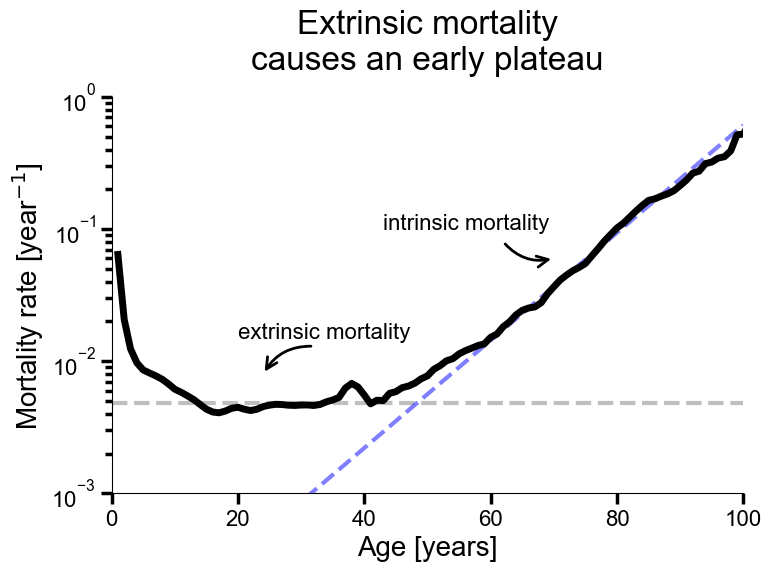

In [ ]:
# Set consistent figure size
subplot_width = 8  # in cm
subplot_height = 6  # in cm

fig, ax = plt.subplots(1, 1, figsize=(subplot_width, subplot_height))  # Convert cm to inches

# ylabel Mortality [1/year] fontsize 20, arial
denmark_female.plot_hazard(ax=ax, years = [1880], custom_colors='black', smooth_window=3, linewidth=5, zorder=1000)

h_ext = denmark_female.get_makeham_term(1880)
h_ext = h_ext
ax.axhline(y=h_ext*1.1, color='grey', linestyle='--', linewidth=3, xmax=1, alpha = 0.5, zorder=0)

denmark_female.plot_gompertz_fit(1880, age_start=60, age_end=80,ax=ax, linewidth=3, alpha = 0.5)

ax.set_ylabel(r'Mortality rate [year$^{-1}$]', fontsize=20, fontname='Arial')
ax.set_xlabel('Age [years]', fontsize=20, fontname='Arial')
# ylim from 10^3 to 1
ax.set_ylim(10**-3, 1)
ax.set_xlim(0, 100)

# Add floating text labels
ax.text(20, 1.5e-2, 'extrinsic mortality', fontsize=16, fontname='Arial')
ax.text(43, 1e-1, 'intrinsic mortality', fontsize=16, fontname='Arial')

# Add title with line break and higher position
ax.set_title('Extrinsic mortality\ncauses an early plateau', fontsize=24, fontname='Arial', pad=20, loc='center')

# hide legend
ax.legend().set_visible(False)

# Add curved arrow pointing to extrinsic hazard line
arrowintrinsic = FancyArrowPatch(
    (62, 0.08),  # starting point (x, y)
    (70, 0.06),  # end point (x, y)
    connectionstyle="arc3,rad=0.3",  # controls the curve (-0.3 means curve to the left)
    arrowstyle="->",
    color="black",
    lw=2,
    mutation_scale=20  # controls arrow head size
)
ax.add_patch(arrowintrinsic)

# Add curved arrow pointing to extrinsic hazard line
arrowextrinsic = FancyArrowPatch(
    (32, 0.013),  # starting point (x, y)
    (24, 0.008),  # end point (x, y)
    connectionstyle="arc3,rad=0.3",  # controls the curve (-0.3 means curve to the left)
    arrowstyle="->",
    color="black",
    lw=2,
    mutation_scale=20  # controls arrow head size
)
ax.add_patch(arrowextrinsic)

plt.tight_layout()



# Fig1B 

period

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


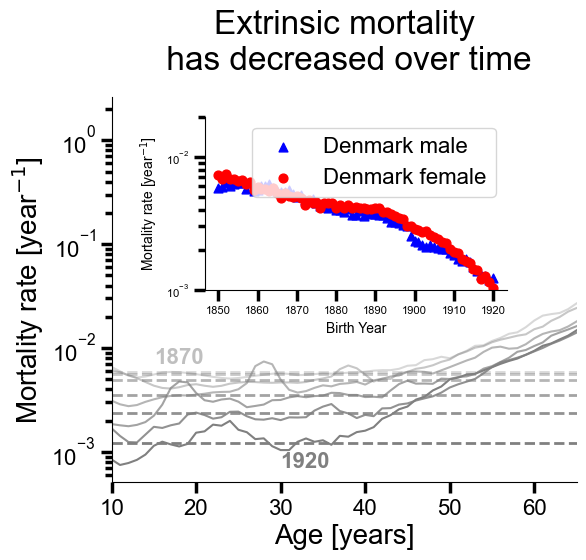

In [ ]:
# Create main figure and axes
fig, ax = plt.subplots(1,1, figsize=(6,5))

# Plot main hazard data
years = [1870, 1880, 1890, 1900, 1910, 1920]

# Calculate alphas for grey colors to match plot_hazard
alphas = np.linspace(0.3, 1.0, len(years))

# Create custom colors with gray and varying alphas
custom_colors = [(0.5, 0.5, 0.5, alpha) for alpha in alphas]  # gray with varying alpha

denmark_female.plot_hazard(ax=ax, years=years, smooth_window=3, custom_colors=custom_colors)
ax.legend().set_visible(False)

for year, alpha in zip(years, alphas):
    h_ext = sweden_female.get_makeham_term(year)
    ax.axhline(y=h_ext, color='gray', linestyle='--', linewidth=2, xmax=1, alpha=alpha, zorder=0)
# Create inset axes
axins = ax.inset_axes([0.2, 0.5, 0.65, 0.45])  # [x, y, width, height] in relative coordinates

# Plot inset data
interval = 5
denmark_male.plot_makeham_term_trend(years = np.arange(1850, 1920 + 1), ax=axins,label = 'Denmark male', color = 'blue')
denmark_female.plot_makeham_term_trend(years = np.arange(1850, 1920 + 1),ax=axins,label = 'Denmark female', color = 'red', marker = 'o')
# remove title
axins.set_title('')

# Remove all grid lines from inset
axins.grid(False)
axins.grid(False, which='both')

# Add x-axis label
axins.set_xlabel('Birth Year', fontsize=10, fontname='Arial')
# Add y-axis label to inset with smaller fontsize
axins.set_ylabel(r'Mortality rate [year$^{-1}$]', fontsize=10, fontname='Arial')
ax.set_ylabel(r'Mortality rate [year$^{-1}$]', fontsize=20, fontname='Arial')
ax.set_xlabel('Age [years]', fontsize=20, fontname='Arial')

# Make tick marks and labels smaller for inset
axins.tick_params(axis='both', which='major', labelsize=8)
axins.tick_params(axis='both', which='minor', labelsize=6)

ax.text(15, 0.007, '1870', fontsize=16, fontname='Arial', weight='bold', color='grey', alpha=0.5)

ax.text(30, 0.0007, '1920', fontsize=16, fontname='Arial', weight='bold', color='grey', alpha=1)

ax.set_xlim(10, 65)

ax.set_title('Extrinsic mortality\n has decreased over time', fontsize=24, fontname='Arial', pad=20, loc='center')

# Add legend
axins.legend()

# Customize inset
axins.set_ylim(0.001, 0.02)



sweden

# Fig 1C-D

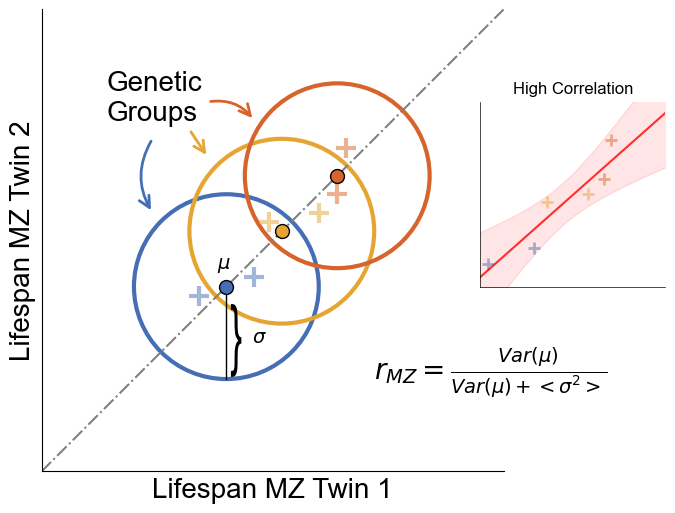

In [ ]:
# import stats
import scipy.stats as stats

# Generate points with offset for asymmetry
offset1 = 0.4
#x1 = 1 + (rad - offset1)/np.sqrt(2) + 0.1
#y1 = 1 - (rad - offset1)/np.sqrt(2)
#x1_offset = x1 - 0.3
#y1_offset = y1 + 0.19
x1 = 0.85; y1 = 0.95
x1_offset = 1.15; y1_offset = 1.05


#offset2 = 0.45
#center2 = 1 + rad_offset   
#x2 = center2 + (rad - offset2)/np.sqrt(2)+0.1
#y2 = center2 - (rad - offset2)/np.sqrt(2)-0.1
#x2_offset = x2 - 0.2
#y2_offset = y2 + 0.2
x2 = 1.5; y2 = 1.4
x2_offset = 1.23; y2_offset = 1.35


#offset3 = 0.35
#center3 = 1 + 2*rad_offset
#x3 = center3 + (rad - offset3)/np.sqrt(2) - 0.1
#y3 = center3 - (rad - offset3)/np.sqrt(2)
#x3_offset = x3  
#y3_offset = y3 +0.25
x3 = 1.6; y3 = 1.5
x3_offset = 1.65; y3_offset = 1.75


# Create figure and axis
fig, ax = plt.subplots(figsize=(8,6))

# Plot circles
rad = 0.5
rad_offset = 0.3
circle1 = plt.Circle((1, 1),rad , color='#466EB4', linewidth=3, fill=False)
circle2 = plt.Circle((1+rad_offset , 1+rad_offset), rad, color='#E6A532', linewidth=3, fill=False)
circle3 = plt.Circle((1+2*rad_offset, 1+2*rad_offset), rad, color='#D7642C', linewidth=3, fill=False)

# Add circles to plot
ax.add_patch(circle1)
ax.add_patch(circle2) 
ax.add_patch(circle3)

# Add center points
size = 100
ax.scatter(1, 1, color='#466EB4', edgecolor='black', facecolor='#466EB4', s=size, zorder=3, linewidth=1)
ax.scatter(1+rad_offset, 1+rad_offset, color='#E6A532', edgecolor='black', facecolor='#E6A532', s=size, zorder=3, linewidth=1)
ax.scatter(1+2*rad_offset, 1+2*rad_offset, color='#D7642C', edgecolor='black', facecolor='#D7642C', s=size, zorder=3, linewidth=1)

ax.plot(x1, y1, color='#466EB4', marker='+', markersize=15, alpha=0.5, markeredgewidth=3)
ax.plot(x1_offset, y1_offset, color='#466EB4', marker='+', markersize=15, alpha=0.5, markeredgewidth=3)

ax.plot(x2, y2, color='#E6A532', marker='+', markersize=15, alpha=0.5, markeredgewidth=3)
ax.plot(x2_offset, y2_offset, color='#E6A532', marker='+', markersize=15, alpha=0.5, markeredgewidth=3)

ax.plot(x3, y3, color='#D7642C', marker='+', markersize=15, alpha=0.5, markeredgewidth=3)
ax.plot(x3_offset, y3_offset, color='#D7642C', marker='+', markersize=15, alpha=0.5, markeredgewidth=3)

# Plot diagonal line
ax.plot([0, 2.5], [0, 2.5], color='grey', linestyle='-.')
ax.text(1.8, 0.5, r'$r_{MZ} = \frac{Var(\mu)}{Var(\mu)+<\sigma^2>}$', fontsize=20)
ax.text(0.35, 1.9, 'Genetic\nGroups', fontsize=20)

# Set axis limits and aspect ratio
ax.set_xlim(0, 2.5)
ax.set_ylim(0, 2.5)
ax.set_aspect('equal')

# Set axis labels
ax.set_xlabel('Lifespan MZ Twin 1', fontsize=20)
ax.set_ylabel('Lifespan MZ Twin 2', fontsize=20)

# Parameter to control tick visibility
show_ticks = False
if not show_ticks:
    ax.set_xticks([])
    ax.set_yticks([])

# Create inset axes
inset_ax = ax.inset_axes([0.85, 0.4, 0.6, 0.4])

# Create arrays of points for correlation using asymmetric points
x_points = [x1, x1_offset, x2, x2_offset, x3, x3_offset]
y_points = [y1, y1_offset, y2, y2_offset, y3, y3_offset]
colors = ['#466EB4', '#466EB4', '#E6A532', '#E6A532', '#D7642C', '#D7642C']

# Plot points on inset
for x, y, c in zip(x_points, y_points, colors):
    inset_ax.plot(x, y, '+', color=c, markersize=8, alpha=0.5, markeredgewidth=2)

# Fit linear regression
x_array = np.array(x_points)
y_array = np.array(y_points)
slope, intercept, r_value, p_value, std_err = stats.linregress(x_array, y_array)
# Create points for regression line
x_reg = np.linspace(0.5, 2.5, 100)
y_reg = slope * x_reg + intercept

# Calculate confidence intervals
mean_x = np.mean(x_array)
n = len(x_points)
S_xx = np.sum((x_array - mean_x)**2)
y_hat = slope * x_array + intercept
std_error = np.sqrt(np.sum((y_array - y_hat)**2) / (n-2))
confidence = 0.95
t_value = stats.t.ppf((1 + confidence) / 2, n - 2)
ci = t_value * std_error * np.sqrt(1/n + (x_reg - mean_x)**2/S_xx)

# Plot regression line and confidence interval
inset_ax.plot(x_reg, y_reg, color='red', alpha=0.8)
inset_ax.fill_between(x_reg, y_reg - ci, y_reg + ci, color='red', alpha=0.1)

# Set inset limits and aspect ratio
inset_ax.set_xlim(0.8, 2)
inset_ax.set_ylim(0.8, 2)
inset_ax.set_aspect('equal')

# Remove ticks from inset
inset_ax.set_xticks([])
inset_ax.set_yticks([])

# Add title to inset
inset_ax.set_title('High Correlation', fontsize=12)

# Add arrows
arrow1 = FancyArrowPatch(
    (0.6, 1.8),
    (0.6, 1.4),
    connectionstyle="arc3,rad=0.3",
    arrowstyle="->",
    color="#466EB4",
    lw=2,
    mutation_scale=20
)
ax.add_patch(arrow1)
ax.text(0.95, 1.1, r'$\mu$', color='black', fontsize=14)

# Add vertical line from center of circle1
ax.plot([1, 1], [1, 0.5], color='black', linewidth=1)


def curly(x,y, scale, ax=None):
    if not ax: ax=plt.gca()
    tp = TextPath((0, 0), "}", size=0.2)
    trans = mtrans.Affine2D().scale(1, scale) + \
        mtrans.Affine2D().translate(x,y) + ax.transData
    pp = PathPatch(tp, lw=0, fc="k", transform=trans)
    ax.add_artist(pp)

curly(1.02, 0.6, 2.1, ax=ax)
# Add sigma label
ax.text(1.14, 0.7, r'$\sigma$', fontsize=14)

arrow2 = FancyArrowPatch(
    (0.9, 2),
    (1.15, 1.9),
    connectionstyle="arc3,rad=-0.3",
    arrowstyle="->",
    color="#D7642C",
    lw=2,
    mutation_scale=20
)
ax.add_patch(arrow2)

arrow3 = FancyArrowPatch(
    (0.8, 1.85),
    (0.9, 1.7),
    connectionstyle="arc3,rad=0",
    arrowstyle="->",
    color="#E6A532",
    lw=2,
    mutation_scale=20
)
ax.add_patch(arrow3)

# Add thin border around inset
for spine in inset_ax.spines.values():
    spine.set_linewidth(0.5)


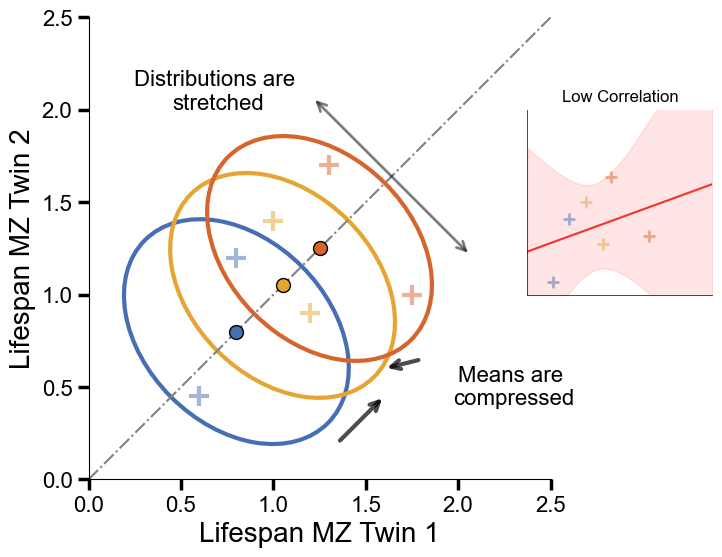

In [ ]:
# import stats
import scipy.stats as stats

# Create figure and axis
fig, ax = plt.subplots(figsize=(8,6))

# Generate points with offset for asymmetry
offset1 = 0.4
#x1 = 1 + (rad - offset1)/np.sqrt(2) + 0.1
#y1 = 1 - (rad - offset1)/np.sqrt(2)
#x1_offset = x1 - 0.3
#y1_offset = y1 + 0.19
x1 = 0.8; y1 = 1.2
x1_offset = 0.6; y1_offset = 0.45


#offset2 = 0.45
#center2 = 1 + rad_offset   
#x2 = center2 + (rad - offset2)/np.sqrt(2)+0.1
#y2 = center2 - (rad - offset2)/np.sqrt(2)-0.1
#x2_offset = x2 - 0.2
#y2_offset = y2 + 0.2
x2 = 1; y2 = 1.4
x2_offset = 1.2; y2_offset = 0.9


#offset3 = 0.35
#center3 = 1 + 2*rad_offset
#x3 = center3 + (rad - offset3)/np.sqrt(2) - 0.1
#y3 = center3 - (rad - offset3)/np.sqrt(2)
#x3_offset = x3  
#y3_offset = y3 +0.25
x3 = 1.75; y3 = 1
x3_offset = 1.3; y3_offset = 1.7

# Define ellipse parameters
rad = 0.5  # b axis (minor)
a = rad + 0.2  # a axis (major)
rad_offset = 0.3

ellipse1_offset = 0.2
ellipse2_offset = 0.25
ellipse3_offset = 0.35

# Create and plot ellipses rotated 45 degrees
angle = 135  # rotation angle in degrees
center1 = (1-ellipse1_offset, 1-ellipse1_offset)
center2 = (1+rad_offset-ellipse2_offset, 1+rad_offset-ellipse2_offset)
center3 = (1+2*rad_offset-ellipse3_offset, 1+2*rad_offset-ellipse3_offset)

ellipse1 = plt.matplotlib.patches.Ellipse(center1, a*2, rad*2, angle=angle, color='#466EB4', linewidth=3, fill=False)
ellipse2 = plt.matplotlib.patches.Ellipse(center2, a*2, rad*2, angle=angle, color='#E6A532', linewidth=3, fill=False)
ellipse3 = plt.matplotlib.patches.Ellipse(center3, a*2, rad*2, angle=angle, color='#D7642C', linewidth=3, fill=False)

# Add ellipses to plot
ax.add_patch(ellipse1)
ax.add_patch(ellipse2)
ax.add_patch(ellipse3)

# Add center points
size = 100
ax.scatter(center1[0], center1[1], color='#466EB4', edgecolor='black', facecolor='#466EB4', s=size, zorder=3, linewidth=1)
ax.scatter(center2[0], center2[1], color='#E6A532', edgecolor='black', facecolor='#E6A532', s=size, zorder=3, linewidth=1)
ax.scatter(center3[0], center3[1], color='#D7642C', edgecolor='black', facecolor='#D7642C', s=size, zorder=3, linewidth=1)

# Generate points perpendicular to diagonal
# For ellipse 1
ax.plot(x1, y1, '#466EB4', marker='+', markersize=15, alpha=0.5, markeredgewidth=3)
ax.plot(x1_offset, y1_offset, '#466EB4', marker='+', markersize=15, alpha=0.5, markeredgewidth=3)
# For ellipse 2
ax.plot(x2, y2, '#E6A532', marker='+', markersize=15, alpha=0.5, markeredgewidth=3)
ax.plot(x2_offset, y2_offset, '#E6A532', marker='+', markersize=15, alpha=0.5, markeredgewidth=3)
# For ellipse 3
ax.plot(x3, y3, '#D7642C', marker='+', markersize=15, alpha=0.5, markeredgewidth=3)
ax.plot(x3_offset, y3_offset, '#D7642C', marker='+', markersize=15, alpha=0.5, markeredgewidth=3)

# Plot diagonal line
ax.plot([0, 2.5], [0, 2.5], color='grey', linestyle='-.')

# Set axis limits and aspect ratio
ax.set_xlim(0, 2.5)
ax.set_ylim(0, 2.5)
ax.set_aspect('equal')

# Set axis labels
ax.set_xlabel('Lifespan MZ Twin 1', fontsize=20)
ax.set_ylabel('Lifespan MZ Twin 2', fontsize=20)

# Remove ticks
show_ticks = True
if not show_ticks:
    ax.set_xticks([])
    ax.set_yticks([])

# Create inset axes
inset_ax = ax.inset_axes([0.85, 0.4, 0.6, 0.4])

# Create arrays of points for correlation
x_points = [x1, x1_offset, x2, x2_offset, x3, x3_offset]
y_points = [y1, y1_offset, y2, y2_offset, y3, y3_offset]
colors = ['#466EB4', '#466EB4', '#E6A532', '#E6A532', '#D7642C', '#D7642C']

# Plot points on inset
for x, y, c in zip(x_points, y_points, colors):
    inset_ax.plot(x, y, '+', color=c, markersize=8, alpha=0.5, markeredgewidth=2)

# Plot regression line
x_reg = np.linspace(0.3, 2.5, 100)
x_points_array = np.array(x_points)
y_points_array = np.array(y_points)

# Fit linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x_points_array, y_points_array)
y_reg = slope * x_reg + intercept

# Calculate confidence intervals
# Get the mean x value
mean_x = np.mean(x_points_array)
# Sum of squared deviations from mean x
n = len(x_points)
sum_sq_x = np.sum((x_points_array - mean_x)**2)
# Standard error of regression
y_pred = slope * x_points_array + intercept
std_err_y = np.sqrt(np.sum((y_points_array - y_pred)**2) / (n-2))
# Calculate confidence intervals
confidence = 0.95
t_value = stats.t.ppf((1 + confidence) / 2, n - 2)
ci = t_value * std_err_y * np.sqrt(1/n + (x_reg - mean_x)**2 / sum_sq_x)

# Plot regression line and confidence interval
inset_ax.plot(x_reg, y_reg, 'red', alpha=0.8)
inset_ax.fill_between(x_reg, y_reg - ci, y_reg + ci, color='red', alpha=0.1)

# Set inset limits and aspect ratio
inset_ax.set_xlim(0.3, 2.5)
inset_ax.set_ylim(0.3, 2.5)
inset_ax.set_aspect('equal')

# Remove ticks from inset
inset_ax.set_xticks([])
inset_ax.set_yticks([])

# Add title to inset
inset_ax.set_title('Low Correlation', fontsize=12)

# Add thin border around inset
for spine in inset_ax.spines.values():
    spine.set_linewidth(0.5)

# Add text annotation
ax.text(2.3, 0.5, 'Means are \ncompressed', 
                 fontsize=16, ha='center', va='center')

# Add text annotation
ax.text(0.7, 2.1, 'Distributions are \nstretched', 
                 fontsize=16, ha='center', va='center')
# Add double-headed arrow perpendicular to diagonal
arrow_x = 1.64  # Position along diagonal
arrow_y = 1.64
arrow_length = 0.6  # Length of arrow in each direction

# Calculate arrow endpoints perpendicular to diagonal
dx = arrow_length/np.sqrt(2)
dy = arrow_length/np.sqrt(2)

# Draw double-headed arrow for spread
ax.annotate('', xy=(arrow_x-dx, arrow_y+dy), xytext=(arrow_x+dx, arrow_y-dy),
            arrowprops=dict(arrowstyle='<->', color='black', lw=2, linestyle='-', alpha=0.5))
# Add arrows as specified
# First arrow from (1.3, 0.3) to (1.55, 0.5)
ax.annotate('', xy=(1.6, 0.45), xytext=(1.35, 0.2),
            arrowprops=dict(arrowstyle='->', color='black', lw=3, linestyle='-', alpha=0.7))

# Second arrow from (1.8, 0.65) to (1.6, 0.6)
ax.annotate('', xy=(1.6, 0.6), xytext=(1.8, 0.65),
            arrowprops=dict(arrowstyle='->', color='black', lw=3, linestyle='-', alpha=0.7))

# add title 
#ax.set_title('      Extrinsic mortality lowers correlations by \n      compressing means and\n      widening distributions', fontsize=20)



c-d combined

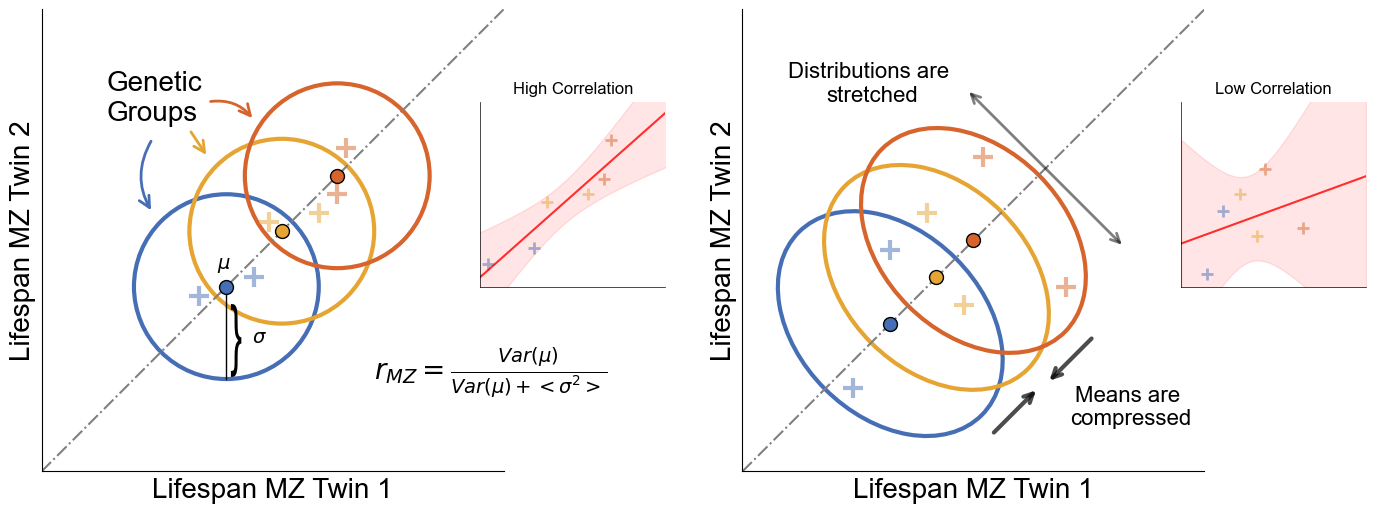

In [ ]:
# Set font to Arial at the beginning
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif']

# Create figure with 2x1 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(wspace=0.3)  # Add whitespace between subplots

# SUBPLOT 1: High Correlation Plot
# Generate points with offset for asymmetry
x1 = 0.85; y1 = 0.95
x1_offset = 1.15; y1_offset = 1.05

x2 = 1.5; y2 = 1.4
x2_offset = 1.23; y2_offset = 1.35

x3 = 1.6; y3 = 1.5
x3_offset = 1.65; y3_offset = 1.75

# Plot circles
rad = 0.5
rad_offset = 0.3
circle1 = plt.Circle((1, 1),rad , color='#466EB4', linewidth=3, fill=False)
circle2 = plt.Circle((1+rad_offset , 1+rad_offset), rad, color='#E6A532', linewidth=3, fill=False)
circle3 = plt.Circle((1+2*rad_offset, 1+2*rad_offset), rad, color='#D7642C', linewidth=3, fill=False)

# Add circles to plot
ax1.add_patch(circle1)
ax1.add_patch(circle2) 
ax1.add_patch(circle3)

# Add center points
size = 100
ax1.scatter(1, 1, color='#466EB4', edgecolor='black', facecolor='#466EB4', s=size, zorder=3, linewidth=1)
ax1.scatter(1+rad_offset, 1+rad_offset, color='#E6A532', edgecolor='black', facecolor='#E6A532', s=size, zorder=3, linewidth=1)
ax1.scatter(1+2*rad_offset, 1+2*rad_offset, color='#D7642C', edgecolor='black', facecolor='#D7642C', s=size, zorder=3, linewidth=1)

ax1.plot(x1, y1, color='#466EB4', marker='+', markersize=15, alpha=0.5, markeredgewidth=3)
ax1.plot(x1_offset, y1_offset, color='#466EB4', marker='+', markersize=15, alpha=0.5, markeredgewidth=3)

ax1.plot(x2, y2, color='#E6A532', marker='+', markersize=15, alpha=0.5, markeredgewidth=3)
ax1.plot(x2_offset, y2_offset, color='#E6A532', marker='+', markersize=15, alpha=0.5, markeredgewidth=3)

ax1.plot(x3, y3, color='#D7642C', marker='+', markersize=15, alpha=0.5, markeredgewidth=3)
ax1.plot(x3_offset, y3_offset, color='#D7642C', marker='+', markersize=15, alpha=0.5, markeredgewidth=3)

# Plot diagonal line
ax1.plot([0, 2.5], [0, 2.5], color='grey', linestyle='-.')
ax1.text(1.8, 0.5, r'$r_{MZ} = \frac{Var(\mu)}{Var(\mu)+<\sigma^2>}$', fontsize=20, fontfamily='Arial')
ax1.text(0.35, 1.9, 'Genetic\nGroups', fontsize=20, fontfamily='Arial')

# Set axis limits and aspect ratio
ax1.set_xlim(0, 2.5)
ax1.set_ylim(0, 2.5)
ax1.set_aspect('equal')

# Set axis labels
ax1.set_xlabel('Lifespan MZ Twin 1', fontsize=20, fontfamily='Arial')
ax1.set_ylabel('Lifespan MZ Twin 2', fontsize=20, fontfamily='Arial')

# Parameter to control tick visibility
ax1.set_xticks([])
ax1.set_yticks([])

# Create inset axes
inset_ax1 = ax1.inset_axes([0.85, 0.4, 0.6, 0.4])

# Create arrays of points for correlation using asymmetric points
x_points = [x1, x1_offset, x2, x2_offset, x3, x3_offset]
y_points = [y1, y1_offset, y2, y2_offset, y3, y3_offset]
colors = ['#466EB4', '#466EB4', '#E6A532', '#E6A532', '#D7642C', '#D7642C']

# Plot points on inset
for x, y, c in zip(x_points, y_points, colors):
    inset_ax1.plot(x, y, '+', color=c, markersize=8, alpha=0.5, markeredgewidth=2)

# Fit linear regression
x_array = np.array(x_points)
y_array = np.array(y_points)
slope, intercept, r_value, p_value, std_err = stats.linregress(x_array, y_array)
# Create points for regression line
x_reg = np.linspace(0.5, 2.5, 100)
y_reg = slope * x_reg + intercept

# Calculate confidence intervals
mean_x = np.mean(x_array)
n = len(x_points)
S_xx = np.sum((x_array - mean_x)**2)
y_hat = slope * x_array + intercept
std_error = np.sqrt(np.sum((y_array - y_hat)**2) / (n-2))
confidence = 0.95
t_value = stats.t.ppf((1 + confidence) / 2, n - 2)
ci = t_value * std_error * np.sqrt(1/n + (x_reg - mean_x)**2/S_xx)

# Plot regression line and confidence interval
inset_ax1.plot(x_reg, y_reg, color='red', alpha=0.8)
inset_ax1.fill_between(x_reg, y_reg - ci, y_reg + ci, color='red', alpha=0.1)

# Set inset limits and aspect ratio
inset_ax1.set_xlim(0.8, 2)
inset_ax1.set_ylim(0.8, 2)
inset_ax1.set_aspect('equal')

# Remove ticks from inset
inset_ax1.set_xticks([])
inset_ax1.set_yticks([])

# Add title to inset
inset_ax1.set_title('High Correlation', fontsize=12, fontfamily='Arial')

# Add arrows
arrow1 = FancyArrowPatch(
    (0.6, 1.8),
    (0.6, 1.4),
    connectionstyle="arc3,rad=0.3",
    arrowstyle="->",
    color="#466EB4",
    lw=2,
    mutation_scale=20
)
ax1.add_patch(arrow1)
ax1.text(0.95, 1.1, r'$\mu$', color='black', fontsize=14, fontfamily='Arial')

# Add vertical line from center of circle1
ax1.plot([1, 1], [1, 0.5], color='black', linewidth=1)

def curly(x,y, scale, ax=None):
    if not ax: ax=plt.gca()
    tp = TextPath((0, 0), "}", size=0.2)
    trans = mtrans.Affine2D().scale(1, scale) + \
        mtrans.Affine2D().translate(x,y) + ax.transData
    pp = PathPatch(tp, lw=0, fc="k", transform=trans)
    ax.add_artist(pp)

curly(1.02, 0.6, 2.1, ax=ax1)
# Add sigma label
ax1.text(1.14, 0.7, r'$\sigma$', fontsize=14, fontfamily='Arial')

arrow2 = FancyArrowPatch(
    (0.9, 2),
    (1.15, 1.9),
    connectionstyle="arc3,rad=-0.3",
    arrowstyle="->",
    color="#D7642C",
    lw=2,
    mutation_scale=20
)
ax1.add_patch(arrow2)

arrow3 = FancyArrowPatch(
    (0.8, 1.85),
    (0.9, 1.7),
    connectionstyle="arc3,rad=0",
    arrowstyle="->",
    color="#E6A532",
    lw=2,
    mutation_scale=20
)
ax1.add_patch(arrow3)

# Add thin border around inset
for spine in inset_ax1.spines.values():
    spine.set_linewidth(0.5)

# SUBPLOT 2: Low Correlation Plot
# Generate points with offset for asymmetry
x1 = 0.8; y1 = 1.2
x1_offset = 0.6; y1_offset = 0.45

x2 = 1; y2 = 1.4
x2_offset = 1.2; y2_offset = 0.9

x3 = 1.75; y3 = 1
x3_offset = 1.3; y3_offset = 1.7

# Define ellipse parameters
rad = 0.5  # b axis (minor)
a = rad + 0.2  # a axis (major)
rad_offset = 0.3

ellipse1_offset = 0.2
ellipse2_offset = 0.25
ellipse3_offset = 0.35

# Create and plot ellipses rotated 45 degrees
angle = 135  # rotation angle in degrees
center1 = (1-ellipse1_offset, 1-ellipse1_offset)
center2 = (1+rad_offset-ellipse2_offset, 1+rad_offset-ellipse2_offset)
center3 = (1+2*rad_offset-ellipse3_offset, 1+2*rad_offset-ellipse3_offset)

ellipse1 = plt.matplotlib.patches.Ellipse(center1, a*2, rad*2, angle=angle, color='#466EB4', linewidth=3, fill=False)
ellipse2 = plt.matplotlib.patches.Ellipse(center2, a*2, rad*2, angle=angle, color='#E6A532', linewidth=3, fill=False)
ellipse3 = plt.matplotlib.patches.Ellipse(center3, a*2, rad*2, angle=angle, color='#D7642C', linewidth=3, fill=False)

# Add ellipses to plot
ax2.add_patch(ellipse1)
ax2.add_patch(ellipse2)
ax2.add_patch(ellipse3)

# Add center points
size = 100
ax2.scatter(center1[0], center1[1], color='#466EB4', edgecolor='black', facecolor='#466EB4', s=size, zorder=3, linewidth=1)
ax2.scatter(center2[0], center2[1], color='#E6A532', edgecolor='black', facecolor='#E6A532', s=size, zorder=3, linewidth=1)
ax2.scatter(center3[0], center3[1], color='#D7642C', edgecolor='black', facecolor='#D7642C', s=size, zorder=3, linewidth=1)

# Generate points perpendicular to diagonal
# For ellipse 1
ax2.plot(x1, y1, '#466EB4', marker='+', markersize=15, alpha=0.5, markeredgewidth=3)
ax2.plot(x1_offset, y1_offset, '#466EB4', marker='+', markersize=15, alpha=0.5, markeredgewidth=3)
# For ellipse 2
ax2.plot(x2, y2, '#E6A532', marker='+', markersize=15, alpha=0.5, markeredgewidth=3)
ax2.plot(x2_offset, y2_offset, '#E6A532', marker='+', markersize=15, alpha=0.5, markeredgewidth=3)
# For ellipse 3
ax2.plot(x3, y3, '#D7642C', marker='+', markersize=15, alpha=0.5, markeredgewidth=3)
ax2.plot(x3_offset, y3_offset, '#D7642C', marker='+', markersize=15, alpha=0.5, markeredgewidth=3)

# Plot diagonal line
ax2.plot([0, 2.5], [0, 2.5], color='grey', linestyle='-.')

# Set axis limits and aspect ratio
ax2.set_xlim(0, 2.5)
ax2.set_ylim(0, 2.5)
ax2.set_aspect('equal')

# Set axis labels
ax2.set_xlabel('Lifespan MZ Twin 1', fontsize=20, fontfamily='Arial')
ax2.set_ylabel('Lifespan MZ Twin 2', fontsize=20, fontfamily='Arial')

# Remove ticks
ax2.set_xticks([])
ax2.set_yticks([])

# Create inset axes
inset_ax2 = ax2.inset_axes([0.85, 0.4, 0.6, 0.4])

# Create arrays of points for correlation
x_points = [x1, x1_offset, x2, x2_offset, x3, x3_offset]
y_points = [y1, y1_offset, y2, y2_offset, y3, y3_offset]
colors = ['#466EB4', '#466EB4', '#E6A532', '#E6A532', '#D7642C', '#D7642C']

# Plot points on inset
for x, y, c in zip(x_points, y_points, colors):
    inset_ax2.plot(x, y, '+', color=c, markersize=8, alpha=0.5, markeredgewidth=2)

# Plot regression line
x_reg = np.linspace(0.3, 2.5, 100)
x_points_array = np.array(x_points)
y_points_array = np.array(y_points)

# Fit linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x_points_array, y_points_array)
y_reg = slope * x_reg + intercept

# Calculate confidence intervals
# Get the mean x value
mean_x = np.mean(x_points_array)
# Sum of squared deviations from mean x
n = len(x_points)
sum_sq_x = np.sum((x_points_array - mean_x)**2)
# Standard error of regression
y_pred = slope * x_points_array + intercept
std_err_y = np.sqrt(np.sum((y_points_array - y_pred)**2) / (n-2))
# Calculate confidence intervals
confidence = 0.95
t_value = stats.t.ppf((1 + confidence) / 2, n - 2)
ci = t_value * std_err_y * np.sqrt(1/n + (x_reg - mean_x)**2 / sum_sq_x)

# Plot regression line and confidence interval
inset_ax2.plot(x_reg, y_reg, 'red', alpha=0.8)
inset_ax2.fill_between(x_reg, y_reg - ci, y_reg + ci, color='red', alpha=0.1)

# Set inset limits and aspect ratio
inset_ax2.set_xlim(0.3, 2.5)
inset_ax2.set_ylim(0.3, 2.5)
inset_ax2.set_aspect('equal')

# Remove ticks from inset
inset_ax2.set_xticks([])
inset_ax2.set_yticks([])

# Add title to inset
inset_ax2.set_title('Low Correlation', fontsize=12, fontfamily='Arial')

# Add thin border around inset
for spine in inset_ax2.spines.values():
    spine.set_linewidth(0.5)

# Add text annotation
ax2.text(2.1, 0.35, 'Means are \ncompressed', 
                 fontsize=16, ha='center', va='center', fontfamily='Arial')

# Add text annotation
ax2.text(0.7, 2.1, 'Distributions are \nstretched', 
                 fontsize=16, ha='center', va='center', fontfamily='Arial')

# Add double-headed arrow perpendicular to diagonal
arrow_x = 1.64  # Position along diagonal
arrow_y = 1.64
arrow_length = 0.6  # Length of arrow in each direction

# Calculate arrow endpoints perpendicular to diagonal
dx = arrow_length/np.sqrt(2)
dy = arrow_length/np.sqrt(2)

# Draw double-headed arrow for spread
ax2.annotate('', xy=(arrow_x-dx, arrow_y+dy), xytext=(arrow_x+dx, arrow_y-dy),
            arrowprops=dict(arrowstyle='<->', color='black', lw=2, linestyle='-', alpha=0.5))

# Add arrows as specified
# First arrow from (1.3, 0.3) to (1.55, 0.5)
ax2.annotate('', xy=(1.6, 0.45), xytext=(1.35, 0.2),
            arrowprops=dict(arrowstyle='->', color='black', lw=3, linestyle='-', alpha=0.7))

# Second arrow from (1.8, 0.65) to (1.6, 0.45)
ax2.annotate('', xy=(1.65, 0.48), xytext =  (1.9, 0.73),
            arrowprops=dict(arrowstyle='->', color='black', lw=3, linestyle='-', alpha=0.7))




# Fig1E-F

In [29]:
t = np.arange(0, 130, 0.5)
def P(t, m=0, b=0.1, a=5e-5):
  """
  Gompertz distribution with external hazard rate m
  """
  bt = b * t
  exp_bt = np.exp(bt)
  return np.exp((a - a * exp_bt - b * m * t)/b) * (a * exp_bt + m)

def probs(t, m=0, b=0.1, a=5e-5):
  p = P(t, m, b, a)
  return p / np.sum(p)

def create_death_times(ages, m=0,b=0.1,a=5e-5, n=1000):
  prob = probs(ages, m, b, a)
  return np.random.choice(ages, size=int(n), p=prob)

def mean_death_times(m=0, b=0.1, a=5e-5, n=1e5):
  t = np.arange(0, 130, 0.1)
  return np.mean(create_death_times(ages=t, m=m, b=b, a=a, n=int(n)))

def var_death_times(m=0, b=0.1, a=5e-5, n=1e5):
  t = np.arange(0, 130, 0.1)
  return np.var(create_death_times(ages=t, m=m, b=b, a=a, n=int(n)))

def plot_twin_deaths(m=0, b=0.1, a=5e-5, n=1000,ax=None,**kwargs):
  if ax == None:
    fig, ax = plt.subplots(1, 1)
  t = np.arange(0, 130, 0.1)
  [deaths1,deaths2] = [create_death_times(ages=t, m=m, b=b, a=a, n=n),create_death_times(ages=t, m=m, b=b, a=a, n=n)]
  # scatter plot deaths1 and deaths2
  ax.scatter(deaths1, deaths2,**kwargs)



# create toy population of 3 population swith same m = 0, a = 5e-5, but b = 0.08, 0.1, 0.12
b_values = [0.08, 0.1, 0.12]
n = 100000
m = 0
a = 5e-5

deaths1 = create_death_times(ages=t, m=m, b=b_values[0], a=a, n=n)
mean1 = mean_death_times(m=m, b=b_values[0], a=a, n=n)
var1 = var_death_times(m=m, b=b_values[0], a=a, n=n)
deaths2 = create_death_times(ages=t, m=m, b=b_values[1], a=a, n=n)
mean2 = mean_death_times(m=m, b=b_values[1], a=a, n=n)
var2 = var_death_times(m=m, b=b_values[1], a=a, n=n)

deaths3 = create_death_times(ages=t, m=m, b=b_values[2], a=a, n=n)
mean3 = mean_death_times(m=m, b=b_values[2], a=a, n=n)
var3 = var_death_times(m=m, b=b_values[2], a=a, n=n)

# Var of mus
var_mus = np.var([mean1, mean2, mean3])
# avg std
avg_var = np.mean([var1, var2, var3])

var_mus / (avg_var + var_mus)

 

0.3737354723795265

(100000,)
(100000,)
(100000,)


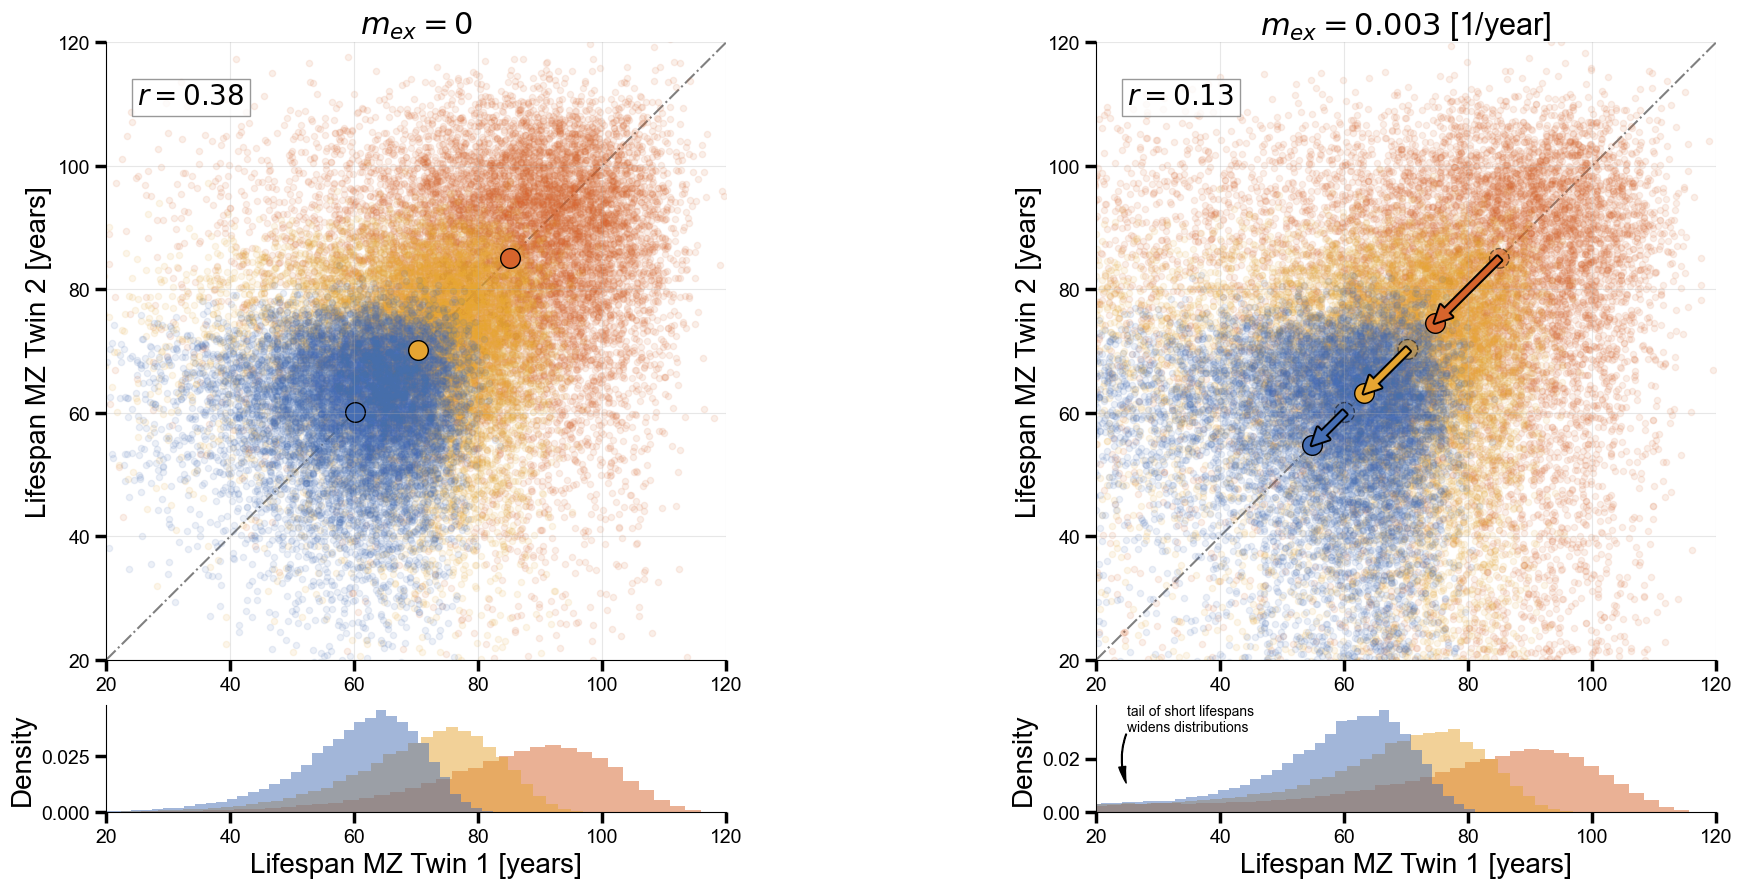

In [ ]:
# Import GridSpec
from matplotlib.gridspec import GridSpec
import copy
from scipy import stats

n_scatter = 10000
n_hist = int(1e5)

# Create figure with GridSpec for side-by-side plots with histograms
fig = plt.figure(figsize=(18, 10))
gs_left = GridSpec(3, 3, height_ratios=[0.8, 0.8, 0.3], width_ratios=[1, 1, 0.2], figure=fig, left=0.05, right=0.45)
gs_right = GridSpec(3, 3, height_ratios=[0.8, 0.8, 0.3], width_ratios=[1, 1, 0.2], figure=fig, left=0.60, right=1.0)

# Create subplots
ax_scatter1 = fig.add_subplot(gs_left[:-1, :-1])  # Left scatter plot
ax_histx1 = fig.add_subplot(gs_left[-1, :-1])  # Left bottom histogram

ax_scatter2 = fig.add_subplot(gs_right[:-1, :-1])  # Right scatter plot
ax_histx2 = fig.add_subplot(gs_right[-1, :-1])  # Right bottom histogram

# Parameters
bs = [0.08, 0.1, 0.12]
colors = ['#466EB4', '#E6A532', '#D7642C']; colors = colors[::-1]
t = np.arange(0, 130, 0.1)

# Left plot (m=0)
all_deaths1_left = []
all_deaths2_left = []

# First plot all scatter points and histograms
for i, b in enumerate(bs):
    deaths1 = create_death_times(ages=t, m=0, b=b, a=5e-5, n=n_hist)
    deaths2 = create_death_times(ages=t, m=0, b=b, a=5e-5, n=n_hist)
    print(deaths1.shape)
    
    plot_twin_deaths(b=b, m=0, ax=ax_scatter1, color=colors[i], s=20, n=n_scatter, alpha=0.1, zorder=1)
    
    hist_vals = ax_histx1.hist(deaths1, bins=50, alpha=0.5, color=colors[i], density=True)
    
    all_deaths1_left.extend(deaths1)
    all_deaths2_left.extend(deaths2)

# Now plot means
for i, b in enumerate(bs):
    mean = mean_death_times(b=b, m=0)
    ax_scatter1.scatter(mean, mean, s=200, edgecolor='black', facecolor=colors[i], marker='o')

# Right plot (m=0.003)
all_deaths1_right = []
all_deaths2_right = []

# First plot all scatter points and histograms
for i, b in enumerate(bs):
    deaths1 = create_death_times(ages=t, m=0.003, b=b, a=5e-5, n=n_hist)
    deaths2 = create_death_times(ages=t, m=0.003, b=b, a=5e-5, n=n_hist)
    
    plot_twin_deaths(b=b, m=0.003, ax=ax_scatter2, color=colors[i], s=20, n=n_scatter, alpha=0.1, zorder=1)
    
    hist_vals = ax_histx2.hist(deaths1, bins=50, alpha=0.5, color=colors[i], density=True)

    all_deaths1_right.extend(deaths1)
    all_deaths2_right.extend(deaths2)

# Now plot means and arrows
for i, b in enumerate(bs):
    mean_hext = mean_death_times(b=b, m=0.003)
    mean = mean_death_times(b=b, m=0)
    
    # Plot final mean point with external hazard
    ax_scatter2.scatter(mean_hext, mean_hext, s=200, edgecolor='black', facecolor=colors[i], marker='o')
    
    # Plot transparent mean point for no external hazard
    ax_scatter2.scatter(mean, mean, s=200, edgecolor='black', facecolor=colors[i], marker='o', linestyle='--', alpha=0.5)
    
    # Plot arrow with path effects
    ax_scatter2.annotate("",
                      xytext=(mean, mean),
                      xy=(mean_hext, mean_hext),
                      arrowprops=dict(
                          color=colors[i],
                          lw=0.1,
                          linestyle="-",
                          mutation_scale=5,
                          path_effects=[
                              path_effects.Stroke(linewidth=3, foreground='black'),
                              path_effects.Normal()
                          ]
                      ))

# Add diagonal lines with dash-dot style
ax_scatter1.plot([20,120], [20,120], color='grey', linestyle='-.', zorder=0)
ax_scatter2.plot([20,120], [20,120], color='grey', linestyle='-.', zorder=0)

# Calculate correlations
r_value_left = stats.pearsonr(all_deaths1_left, all_deaths2_left)[0]
r_value_right = stats.pearsonr(all_deaths1_right, all_deaths2_right)[0]

# Format plots
fonts = 20

# Set limits and labels
for ax in [ax_scatter1, ax_scatter2]:
    ax.set_xlim(20, 120)
    ax.set_ylim(20, 120)
    ax.set_ylabel('Lifespan MZ Twin 2 [years]', fontsize=20)
    ax.set_xlabel('')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='both', which='major', labelsize=14)

# Set labels and limits for histograms
for ax in [ax_histx1, ax_histx2]:
    ax.grid(False)
    ax.set_xlabel('Lifespan MZ Twin 1 [years]', fontsize=20)
    ax.set_ylabel('Density', fontsize=20)
    ax.set_xlim(20, 120)
    ax.tick_params(axis='both', which='major', labelsize=14)

# Add titles and correlation text boxes
ax_scatter1.set_title('$m_{ex}=0$', fontsize=22)
ax_scatter2.set_title('$m_{ex}=0.003$ [1/year]', fontsize=22)

# Add correlation text boxes
ax_scatter1.text(25, 110, f'$r={r_value_left:.2f}$', 
                fontsize=20, bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
ax_scatter2.text(25, 110, f'$r={r_value_right:.2f}$', 
                fontsize=20, bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

# Add text annotation for histogram
ax_histx2.text(25, 0.03, 'tail of short lifespans\nwidens distributions', 
              fontsize=10)
ax_histx2.annotate('', xy=(25, 0.01), xytext=(25, 0.03),
                  arrowprops=dict(facecolor='black', shrink=0.05, connectionstyle="arc3,rad=0.2", width=0.5, headwidth=5))

plt.show()

